In [2]:
!pip install pyLDAvis
!pip install lda
!pip install gensim
import re # We clean text using regex
import csv # To read the csv
import pandas as pd 
import numpy as np
from collections import defaultdict # For accumlating values
from nltk.corpus import stopwords # To remove stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize 
from nltk.tokenize import PunktSentenceTokenizer, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from gensim import corpora # To create corpus and dictionary for the LDA model
from gensim.models import LdaModel # To use the LDA model
import pyLDAvis.gensim # To visualise LDA model effectively
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')
import nltk
import lda
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')


  Created wheel for smart-open: filename=smart_open-1.9.0-cp37-none-any.whl size=73092 sha256=66c2854b2ec4b9703b78fd18e4dce6c34f9ec25b03db800b4f6d3612d8ca6d41
  Stored in directory: C:\Users\wh_el\AppData\Local\pip\Cache\wheels\ab\10\93\5cff86f5b721d77edaecc29959b1c60d894be1f66d91407d28
Successfully built smart-open


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wh_el\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wh_el\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\wh_el\AppData\Roaming\nltk_data...


True

## Data Preprocessing

In [3]:
Four_Seasons = pd.read_csv('Four_Seasons_reviews.csv')
Hilton = pd.read_csv('Hilton_reviews.csv')
Hotel_ZaZa = pd.read_csv('Hotel_ZaZa_Austin_reviews.csv')
InterContinental = pd.read_csv('InterContinental_reviews.csv')
JW_Marriott = pd.read_csv('JW_Marriott_reviews.csv')
Kimpton_Hotel_Van_Zandt = pd.read_csv('Kimpton_Hotel_Van_Zandt_reviews.csv')
Omni = pd.read_csv('Omni_Austin_Hotel_Downtown-Austin_reviews.csv')
The_Driskill = pd.read_csv('The_Driskill_reviews.csv')
Westin = pd.read_csv('The_Westin_Austin_Downtown_reviews.csv')
W_Austin = pd.read_csv('W_Austin_reviews.csv')

In [4]:
Four_Seasons['hotel'] = 'seasons'
Hilton['hotel'] = 'hilton'
Hotel_ZaZa['hotel'] = 'zaza'
InterContinental['hotel'] = 'continental'
JW_Marriott['hotel'] = 'marriott'
Kimpton_Hotel_Van_Zandt['hotel'] = 'kimpton'
Omni['hotel'] = 'omni'
The_Driskill['hotel'] = 'driskill' 
Westin['hotel'] = 'westin'
W_Austin['hotel'] = 'w'

In [5]:
downtown_reviews = pd.concat([Four_Seasons,
Hilton,
Hotel_ZaZa,
InterContinental,
JW_Marriott,
Kimpton_Hotel_Van_Zandt,
Omni,
The_Driskill,
Westin,
W_Austin])

In [6]:
downtown_reviews.head()

,rating,title,review,hotel
0,5,"Excellent, but pricey","The service, the rooms, and the common spaces ...",seasons
1,5,Four Seasons - Austin,Great place to stay in Austin. Great facility ...,seasons
2,5,Four Seasons Halloween Wedding Stay,I cannot say enough about how wonderful the st...,seasons
3,5,Awesome customer service!,The team at this hotel is awesome. Even when y...,seasons
4,5,"Beautiful, classy & comfortable.",Our 9:30 PM flight from NY to Austin was delay...,seasons


In [23]:
downtown_reviews.groupby(['hotel'])[['rating']].agg(['mean','count'])

rating      
                 mean count
hotel                      
continental  4.492000   500
driskill     4.312000   500
hilton       4.242000   500
kimpton      4.326000   500
marriott     4.567347   490
omni         3.984000   500
seasons      4.598000   500
w            4.306000   500
westin       4.428000   500
zaza         4.733333    30

#### All hotels have almost 500 customer reviews except zaza since zaza is a new hotel. Also, we can see that the average rating of each hotel is above 4.0 except omni.

### Remove common words and stopwords

In [7]:
def remove(word,df):
    for i in range(len(df)):
        df[i] = df[i].lower()
        if word in df[i]:
            df[i] = df[i].replace(word, '')
        else:
            pass
        return df
def filter_word(comment):
    stop_words = set(stopwords.words('english'))
    word = re.findall(r'\w+',comment)
    filtered_sentence = ''
    for w in word: 
        if w.lower() not in stop_words: 
            filtered_sentence +=' '
            filtered_sentence += w    
    return filtered_sentence

In [8]:
df= downtown_reviews.copy().reset_index()

In [9]:
sia = SentimentIntensityAnalyzer()

In [10]:
remove('hotel',df['review'])
remove('austin',df['review'])
for i in range(len(df['review'])):
    df['review'][i] = filter_word(df['review'][i])

In [25]:
# use sentiment intensity analyzer to analyze sentiment of customer reviews 
# It will return four scores for each review: positive score, negative score, neural score and compound score
df['neg'] = df['review'].apply(lambda x:sia.polarity_scores(x)['neg'])
df['neu'] = df['review'].apply(lambda x:sia.polarity_scores(x)['neu'])
df['pos'] = df['review'].apply(lambda x:sia.polarity_scores(x)['pos'])
df['compound'] = df['review'].apply(lambda x:sia.polarity_scores(x)['compound'])

In [26]:
sent = df.groupby(["hotel"]).mean()

In [27]:
sent

,index,rating,neg,neu,pos,compound
hotel,,,,,,
continental,249.5,4.492000,0.030906,0.586498,0.382584,0.854592
driskill,249.5,4.312000,0.042590,0.594422,0.362990,0.817989
hilton,249.5,4.242000,0.043774,0.608970,0.347260,0.813259
kimpton,249.5,4.326000,0.037970,0.589234,0.372798,0.859354
marriott,244.5,4.567347,0.034559,0.565996,0.399451,0.834368
omni,249.5,3.984000,0.052710,0.612182,0.335124,0.717485
seasons,249.5,4.598000,0.030424,0.600018,0.369542,0.836534
w,249.5,4.306000,0.037910,0.595434,0.366666,0.881128
westin,249.5,4.428000,0.040618,0.572986,0.386374,0.818025


From the result of sentiment analysis, it is clear that:

(1)The compound score gives us the same outcome as rating. Omni has the lowest score both for rating and compound score. Zaza has the highest score both for rating and compound score as well. 

(2)The positive score is higher than negative score for every hotel since these are all luxury hotels that are most likely to leave a positive impression on customers and although there may be something not satisfied by customers, hotels provided customers with nice environment and service in general. So, rating score and compound score are both high. In the next step, the problem is that we need to figure out what negative topics customers are complaining about in those general positive reviews.

In [28]:
sent.to_csv("sentiment_hotel.csv", sep = ",")


Next, we go deep into positive and negative reviews to figure out what topics customers are favor of or complaining about for each hotel, in order to give conclusions of advantages and disadvantages of each hotel.

In [29]:
df

,index,rating,title,review,hotel,neg,neu,pos,compound
0,0,5,"Excellent, but pricey",service rooms common spaces excellent annual ...,seasons,0.000,0.792,0.208,0.6705
1,1,5,Four Seasons - Austin,Great place stay Austin Great facility friend...,seasons,0.000,0.543,0.457,0.9781
2,2,5,Four Seasons Halloween Wedding Stay,cannot say enough wonderful staff Four Season...,seasons,0.159,0.637,0.204,0.4027
3,3,5,Awesome customer service!,team hotel awesome Even check mid night every...,seasons,0.000,0.503,0.497,0.9571
4,4,5,"Beautiful, classy & comfortable.",9 30 PM flight NY Austin delayed hour got hot...,seasons,0.117,0.720,0.163,0.7269
...,...,...,...,...,...,...,...,...,...
4515,495,4,Spartan Super Weekend,Love W awarded Priceline express deals excite...,w,0.125,0.506,0.369,0.9186
4516,496,5,Breathtaking,town wedding hotel blown away hospitality pla...,w,0.000,0.508,0.492,0.9378
4517,497,4,Great hotel staff and very clean,W Austin staff best come across first interac...,w,0.023,0.512,0.465,0.9957
4518,498,4,Trendy Zone,corridors wouldnt look place starship cosy ro...,w,0.000,0.843,0.157,0.8074


### WordCount and Lift analysis

In [40]:
# Extract positive reviews if compound score is higher than 0.2
# Extract negative reviews if compound score is lower than -0.1
pos_rev = df[df['compound']>0.2]['review']
neg_rev = df[df['compound']< -0.1]['review']

In [30]:
def word_count(comment): 
    word_dict = {}
    word = re.findall(r'\w+',comment)
    for j in word:
        if j not in word_dict:
            word_dict[j] = 1
    return word_dict

In [31]:
outer_dict = {}
for i in df['review']:
    inner_dict = {}
    i = i.lower() 
    filter_comment = filter_word(i) # remove stopwords
    inner_dict = word_count(filter_comment) # count words in the review
    for key, value in inner_dict.items():
        if key not in outer_dict:
            outer_dict[key] = 1
        else:
            outer_dict[key] += 1

In [36]:
word_freq = pd.DataFrame(data = outer_dict,index=['freq'])
word_freq.T.sort_values(by='freq',ascending=False)
word_freq.T.to_csv("word_freq.csv", sep=",")

In [42]:
word_freq.T.sort_values(by='freq',ascending=False)[:30]

,freq
hotel,2885
room,2123
staff,2043
great,2041
austin,1785
stay,1667
service,1413
location,1413
rooms,1222
nice,1144


Based on the top 30 most mentioned words, we selected 8 attributes as following:

In [45]:
attributes = ['room','staff','service','location','street','food','restaurant','desk']
# Lift analysis to see the lift of hotel brands and attributes

In [46]:
def single_word_count(word, comment_list):
    count = 0
    for comment in comment_list:
        comment = comment.lower()
        comment_list = re.findall(r'\w+',comment)
        if word in comment_list:
            count += 1
    return count

def pair_word_count(word1,word2, comment_list):
    count = 0
    for comment in comment_list:
        comment = comment.lower()
        comment_list = re.findall(r'\w+',comment)
        if word1 in comment_list and word2 in comment_list:
            count += 1
    return count

def lift(A, B, N, comment_list):
    return N * float(pair_word_count(A,B,comment_list)) /(single_word_count(A,comment_list)*single_word_count(B,comment_list))

In [49]:
brands = ['seasons','hilton','zaza','continental','marriott','kimpton','omni','driskill','westin','w']
att_lift=np.zeros((10,8))
for x in range(len(brands)):
    for y in range(len(attributes)):
            att_lift[x][y] = (lift(brands[x],attributes[y],len(df['review']),df['review']))

In [50]:
lift_attribute = pd.DataFrame(att_lift)
lift_attribute.columns = attributes
lift_attribute.index = brands
lift_attribute

,room,staff,service,location,street,food,restaurant,desk
seasons,0.883603,1.023141,1.529893,0.897706,0.497079,1.057681,1.135644,0.903159
hilton,1.170984,0.962408,0.911677,1.151592,1.738462,0.756242,0.911008,1.392417
zaza,0.870980,0.703956,1.163225,0.436209,0.000000,1.057681,0.637068,1.298291
continental,0.967756,1.005651,0.872418,1.454031,0.672519,0.528841,1.274137,1.947436
marriott,1.122597,0.965425,1.182612,0.736709,0.358677,1.092937,0.806953,1.557949
kimpton,1.380381,1.094060,0.949115,1.124877,2.357512,1.470293,2.002215,1.333958
omni,0.965640,1.015543,0.996369,1.136210,1.414862,0.826494,0.497818,1.092551
driskill,1.042582,0.809705,0.989341,0.939873,1.715963,1.409333,0.830816,0.809759
westin,0.904576,0.939997,1.060764,0.878446,0.958252,0.904235,1.561313,1.479917
w,1.285472,0.911411,1.156823,1.026052,0.767687,0.896368,0.969626,1.145191


From lift table, lift score>1: (since we only focus on lift score is higher than 1)

(1)Four season: service, restaurant, food, staff

(2)Hilton: Location, room, street, desk

(3)zaza: service, food, desk

(4)Intercontinental: desk, staff, Location, restaurant

(5)JW marriott: room, service, desk, food

(6)kimpton:  street (lift score>2), restaurant(lift score>2), room, desk, location, staff, food

(7)omni: street, desk, location, staff

(8)The driskill: street, food, room

(9)Westin: restaurant, desk, service

(10)W_austin: room, desk, service, location

In [171]:
def attr_sentiment(attributes, df_hotel):
    shorten_df = []
    for i in attributes:
        for j in df_hotel:
            j = j.split() 
            if i in j:
                index = j.index(i)
                shorten_df.append([i, " ".join(j[index-4:index + 4])])
      
    shorten_df = pd.DataFrame(shorten_df)
    shorten_df.columns = ['attribute','attribute_review']
    shorten_df = shorten_df[shorten_df['attribute_review'] != ""]
    shorten_df['neg'] = shorten_df['attribute_review'].apply(lambda x:sia.polarity_scores(x)['neg'])
    shorten_df['neu'] = shorten_df['attribute_review'].apply(lambda x:sia.polarity_scores(x)['neu'])
    shorten_df['pos'] = shorten_df['attribute_review'].apply(lambda x:sia.polarity_scores(x)['pos'])
    shorten_df['compound'] = shorten_df['attribute_review'].apply(lambda x:sia.polarity_scores(x)['compound'])
    shorten_df = shorten_df.groupby("attribute")[['compound','neg','pos']].agg(['mean'])
    return shorten_df


In [172]:
for i in brands:
    df_fseason = df[df['hotel'] == i]['review']
    att_fseason = lift_attribute.loc[i][lift_attribute.loc[i] > 1].index.values # ONLY focus on those lift pairs are higher than 1.
    print(i)
    shorten_df = attr_sentiment(att_fseason, df_fseason)
    shorten_df = pd.DataFrame(shorten_df)
    shorten_df = shorten_df.reset_index()
    print(shorten_df)
    print(" ")

seasons
    attribute  compound       neg       pos
                   mean      mean      mean
0        food  0.568073  0.028434  0.423843
1  restaurant  0.412280  0.031338  0.329723
2     service  0.456609  0.021722  0.341225
3       staff  0.569411  0.021315  0.429335
 
hilton
  attribute  compound       neg       pos
                 mean      mean      mean
0      desk  0.343448  0.036431  0.279862
1  location  0.598867  0.020252  0.440121
2      room  0.393979  0.031863  0.316635
3    street  0.193138  0.055227  0.175091
 
zaza
  attribute  compound  neg       pos
                 mean mean      mean
0      desk  0.613660  0.0  0.443400
1      food  0.594475  0.0  0.447750
2   service  0.602273  0.0  0.411545
 
continental
    attribute  compound       neg       pos
                   mean      mean      mean
0        desk  0.317391  0.039692  0.261756
1    location  0.601360  0.023573  0.449976
2  restaurant  0.519516  0.007294  0.376912
3       staff  0.610721  0.011026  0.4506


Also, we hoped to figure out whether customers were likely to co-mention two hotels in one review.

Here is the lift table of brands pairwise.


In [173]:
brand_lift=np.zeros((10,10))
for x in range(len(brands)):
    for y in range(len(brands)):
        if x == y:
            brand_lift[x][y] = 1
        else:
            brand_lift[x][y] = (lift(brands[x],brands[y],len(df_review),df_review))
pd.DataFrame(brand_lift)


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.050266,0.259962,0.084436,0.156261,0.085276,0.067549,0.166902,0.115706,0.288092
1,0.050266,1.000000,0.267578,0.156438,0.160839,0.070219,0.052146,0.068717,0.068055,0.082370
2,0.259962,0.267578,1.000000,0.269685,0.748634,0.272366,0.809055,0.266537,0.263969,0.766791
3,0.084436,0.156438,0.269685,1.000000,0.064842,0.035386,0.052557,0.173144,0.068590,0.099622
4,0.156261,0.160839,0.748634,0.064842,1.000000,0.081859,0.081053,0.032043,0.460143,0.445549
5,0.085276,0.070219,0.272366,0.035386,0.081859,1.000000,0.017693,0.069946,0.069272,0.083844
6,0.067549,0.052146,0.809055,0.052557,0.081053,0.017693,1.000000,0.051943,0.120033,0.083019
7,0.166902,0.068717,0.266537,0.173144,0.032043,0.069946,0.051943,1.000000,0.101685,0.082050
8,0.115706,0.068055,0.263969,0.068590,0.460143,0.069272,0.120033,0.101685,1.000000,0.211274
9,0.288092,0.082370,0.766791,0.099622,0.445549,0.083844,0.083019,0.082050,0.211274,1.000000



All the lift pairwise are below 1 so there is no co-mentions between hotel brands.


### LDA Topic Modeling

In [175]:
df['review_hotel'] = df['hotel'] + " "+ df['review']
df_review = list(df['review_hotel'])
brand_line = " ".join(brands)
df_review.append(brand_line)

In [174]:
w_token=RegexpTokenizer(r'\w+')
w_lemma = WordNetLemmatizer()
stop =set(stopwords.words('english'))
def tokenize(version_desc):
    text = w_lemma.lemmatize(version_desc.lower())
    tokens = w_token.tokenize(text)
    return tokens

In [180]:
df_copy = df.copy()
remove('austin',df_copy['review'])
remove('hotel',df_copy['review'])
remove('would',df_copy['review'])
remove('could',df_copy['review'])
#remove('great',df_copy['review'])
#remove('good',df_copy['review'])
#remove('nice',df_copy['review'])
vec = CountVectorizer(tokenizer=tokenize, stop_words=stop, decode_error='ignore')
words = vec.fit_transform(df_copy['review'])

model = lda.LDA(n_topics = 4, n_iter = 500, random_state = 10)
model.fit(words)


INFO:lda:n_documents: 4520
INFO:lda:vocab_size: 11900
INFO:lda:n_words: 202409
INFO:lda:n_topics: 4
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -1898633
INFO:lda:<10> log likelihood: -1709698
INFO:lda:<20> log likelihood: -1673550
INFO:lda:<30> log likelihood: -1649250
INFO:lda:<40> log likelihood: -1635783
INFO:lda:<50> log likelihood: -1625948
INFO:lda:<60> log likelihood: -1621832
INFO:lda:<70> log likelihood: -1617307
INFO:lda:<80> log likelihood: -1614071
INFO:lda:<90> log likelihood: -1612727
INFO:lda:<100> log likelihood: -1611191
INFO:lda:<110> log likelihood: -1611080
INFO:lda:<120> log likelihood: -1609161
INFO:lda:<130> log likelihood: -1609415
INFO:lda:<140> log likelihood: -1609088
INFO:lda:<150> log likelihood: -1608624
INFO:lda:<160> log likelihood: -1607782
INFO:lda:<170> log likelihood: -1607315
INFO:lda:<180> log likelihood: -1607476
INFO:lda:<190> log likelihood: -1606283
INFO:lda:<200> log likelihood: -1606074
INFO:lda:<210> log likelihood: -1605735
INFO:lda:<

In [204]:
topic_word = model.topic_word_
df_topic = pd.DataFrame(model.doc_topic_)
df_new = df_copy.join(df_topic)

df_pos = pd.DataFrame()

In [205]:
for i in range(4):
    topic = 'topic_'+str(i)
    df_pos[topic]=df_new.groupby(["review"])[i].mean()

df_pos = df_pos.reset_index()
topics = pd.DataFrame(topic_word)
topics.columns = vec.get_feature_names()
topics = topics.T

In [183]:
topics.sort_values(0, ascending=False).head(10) #staff and service

,0,1,2,3
staff,0.024978,1.609685e-03,1.484575e-02,8.950837e-05
great,0.021829,1.768691e-07,2.753875e-02,4.453153e-07
stay,0.020131,7.145687e-03,1.011001e-02,4.453153e-07
service,0.017230,4.581086e-03,8.224614e-03,4.453153e-07
room,0.009641,3.463114e-02,1.674599e-02,4.498130e-03
us,0.009411,6.809636e-03,1.484561e-07,1.425454e-03
time,0.008155,5.606926e-03,3.132571e-03,4.453153e-07
experience,0.007288,2.476344e-03,8.760392e-04,4.453153e-07
friendly,0.007182,1.768691e-07,8.476989e-03,8.020128e-04
location,0.006970,1.768691e-07,1.690929e-02,4.453153e-07


In [184]:
topics.sort_values(1, ascending=False).head(10)  ##room

,0,1,2,3
room,0.009641,0.034631,1.674599e-02,4.498130e-03
one,0.005767,0.008348,2.405137e-03,5.789544e-03
get,0.001079,0.007499,2.479365e-03,3.785625e-03
stay,0.020131,0.007146,1.011001e-02,4.453153e-07
night,0.002689,0.007040,3.295873e-03,9.530192e-03
desk,0.005820,0.006951,6.088183e-04,4.453153e-07
us,0.009411,0.006810,1.484561e-07,1.425454e-03
check,0.004263,0.006456,1.113569e-03,4.008283e-03
front,0.005449,0.006120,9.502672e-04,4.453153e-07
like,0.004281,0.006067,2.405137e-03,4.453153e-07


In [185]:
topics.sort_values(2, ascending=False).head(10) #location

,0,1,2,3
great,2.182929e-02,1.768691e-07,0.027539,4.453153e-07
location,6.969927e-03,1.768691e-07,0.016909,4.453153e-07
room,9.641076e-03,3.463114e-02,0.016746,4.498130e-03
nice,3.431983e-03,4.351156e-03,0.016672,4.453153e-07
staff,2.497806e-02,1.609685e-03,0.014846,8.950837e-05
rooms,6.598443e-03,4.457277e-03,0.012352,4.453153e-07
bar,3.998054e-03,1.768691e-07,0.012292,3.251247e-03
good,1.769149e-03,3.997418e-03,0.011565,6.684182e-04
pool,3.661949e-03,1.768691e-07,0.011476,7.080958e-03
street,1.768972e-07,1.768691e-07,0.010110,2.894995e-03


In [186]:
topics.sort_values(3, ascending=False).head(10) #entertainment

,0,1,2,3
parking,1.768972e-07,1.768691e-07,0.001158,0.017991
valet,2.229082e-03,1.768691e-07,0.001143,0.012692
breakfast,1.220768e-03,1.768691e-07,0.003311,0.010822
night,2.689015e-03,7.039566e-03,0.003296,0.009530
hour,1.768972e-07,1.768691e-07,0.001010,0.008729
pool,3.661949e-03,1.768691e-07,0.011476,0.007081
free,1.768972e-07,7.430269e-04,0.001366,0.006725
5,6.370069e-04,1.698120e-03,0.000460,0.006591
coffee,1.768972e-07,1.132139e-03,0.001782,0.006279
one,5.767026e-03,8.348397e-03,0.002405,0.005790


In [206]:
df_pos = df_pos.set_index('review')
df_pos.columns = ['staff and service','room','location','entertainment']

df_pos['labels'] = df_pos.T.idxmax()
df_pos_entertainment = df_pos[df_pos['labels'] == "entertainment"]
df_pos_location = df_pos[df_pos['labels'] == "location"]
df_pos_staff_service = df_pos[df_pos['labels'] == "staff and service"]
df_room = df_pos[df_pos['labels'] == "room"]
df_pos_entertainment  = df_pos_entertainment.reset_index()
df_pos_location = df_pos_location.reset_index()
df_pos_staff_service = df_pos_staff_service.reset_index()
df_room = df_room.reset_index()



### WordCloud

In [188]:
!pip install wordcloud
from wordcloud import WordCloud

### (1)Staff and service

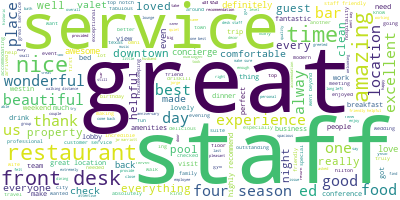

In [189]:
# Join the different processed titles together.
remove('stay',df_pos_entertainment['review'])
remove('room',df_pos_entertainment['review'])
long_string = ','.join(list(df_pos_entertainment['review']))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### (2)Location

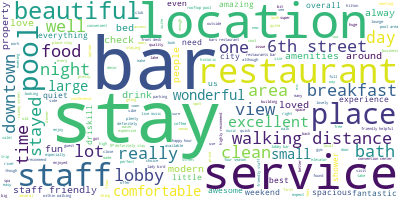

In [208]:
remove('room',df_pos_location['review'])
remove('great',df_pos_location['review'])
remove('nice',df_pos_location['review'])
remove('good',df_pos_location['review'])
long_string = ','.join(list(df_pos_location['review']))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

### (3)Room

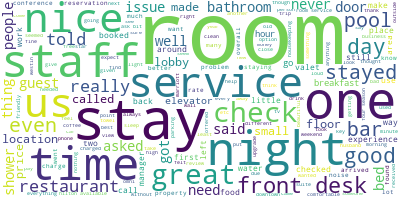

In [207]:
long_string = ','.join(list(df_room['review']))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

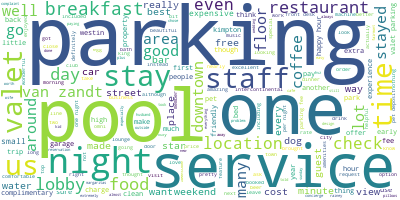

In [211]:
remove('room',df_pos_entertainment['review'])
remove('nice',df_pos_entertainment['review'])
remove('great',df_pos_entertainment['review'])
long_string = ','.join(list(df_pos_entertainment['review']))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [212]:
df_pos_entertainment['neg'] = df_pos_entertainment['review'].apply(lambda x:sia.polarity_scores(x)['neg'])
df_pos_entertainment['neu'] = df_pos_entertainment['review'].apply(lambda x:sia.polarity_scores(x)['neu'])
df_pos_entertainment['pos'] = df_pos_entertainment['review'].apply(lambda x:sia.polarity_scores(x)['pos'])
df_pos_entertainment['compound'] = df_pos_entertainment['review'].apply(lambda x:sia.polarity_scores(x)['compound'])

df_pos_location['neg'] = df_pos_location['review'].apply(lambda x:sia.polarity_scores(x)['neg'])
df_pos_location['neu'] = df_pos_location['review'].apply(lambda x:sia.polarity_scores(x)['neu'])
df_pos_location['pos'] = df_pos_location['review'].apply(lambda x:sia.polarity_scores(x)['pos'])
df_pos_location['compound'] = df_pos_location['review'].apply(lambda x:sia.polarity_scores(x)['compound'])

df_pos_staff_service['neg'] = df_pos_staff_service['review'].apply(lambda x:sia.polarity_scores(x)['neg'])
df_pos_staff_service['neu'] = df_pos_staff_service['review'].apply(lambda x:sia.polarity_scores(x)['neu'])
df_pos_staff_service['pos'] = df_pos_staff_service['review'].apply(lambda x:sia.polarity_scores(x)['pos'])
df_pos_staff_service['compound'] = df_pos_staff_service['review'].apply(lambda x:sia.polarity_scores(x)['compound'])

df_room['neg'] = df_room['review'].apply(lambda x:sia.polarity_scores(x)['neg'])
df_room['neu'] = df_room['review'].apply(lambda x:sia.polarity_scores(x)['neu'])
df_room['pos'] = df_room['review'].apply(lambda x:sia.polarity_scores(x)['pos'])
df_room['compound'] = df_room['review'].apply(lambda x:sia.polarity_scores(x)['compound'])


In [214]:
print(len(df_pos_entertainment[df_pos_entertainment['compound'] < 0]) / len(df_pos_entertainment))

print(len(df_pos_entertainment[df_pos_entertainment['compound'] == 0]) / len(df_pos_entertainment))

print(len(df_pos_entertainment[df_pos_entertainment['compound'] > 0]) / len(df_pos_entertainment))

0.08571428571428572
0.0
0.9142857142857143


In [215]:
print(len(df_pos_location[df_pos_location['compound'] < 0]) / len(df_pos_location))

print(len(df_pos_location[df_pos_location['compound'] == 0]) / len(df_pos_location))

print(len(df_pos_location[df_pos_location['compound'] > 0]) / len(df_pos_location))

0.029661016949152543
0.00847457627118644
0.961864406779661


In [216]:
print(len(df_pos_staff_service[df_pos_staff_service['compound'] < 0]) / len(df_pos_staff_service))

print(len(df_pos_staff_service[df_pos_staff_service['compound'] == 0]) / len(df_pos_staff_service))

print(len(df_pos_staff_service[df_pos_staff_service['compound'] > 0]) / len(df_pos_staff_service))

0.011278195488721804
0.002506265664160401
0.9862155388471178


In [217]:
print(len(df_room[df_room['compound'] < 0]) / len(df_room))

print(len(df_room[df_room['compound'] == 0]) / len(df_room))

print(len(df_room[df_room['compound'] > 0]) / len(df_room))

0.18682505399568033
0.009719222462203024
0.8034557235421166


In [218]:
df_room[df_room['compound'] < 0]

,review,staff and service,room,location,entertainment,labels,neg,neu,pos,compound
2,boasts conde nast top 10 s texas decided try...,0.186756,0.595982,0.060268,0.156994,room,0.137,0.728,0.135,-0.3400
19,give place zero stars give kimpton horrible...,0.137295,0.622268,0.000683,0.239754,room,0.133,0.840,0.027,-0.9403
20,good location housekeeping worst ever experi...,0.194268,0.735669,0.066879,0.003185,room,0.213,0.644,0.144,-0.4215
28,great location high expectations since full ...,0.317568,0.610360,0.002252,0.069820,room,0.220,0.604,0.176,-0.5574
32,hip business model traditional hallway room ...,0.045259,0.691810,0.088362,0.174569,room,0.131,0.758,0.112,-0.2500
...,...,...,...,...,...,...,...,...,...,...
918,worst stay years one thing pay 600 night lux...,0.187695,0.382399,0.242212,0.187695,room,0.153,0.731,0.116,-0.6830
919,worst bed ever sank middle sleep edge easy ch...,0.086066,0.741803,0.168033,0.004098,room,0.374,0.543,0.083,-0.8807
920,worst experience long time charged twice one ...,0.090116,0.526163,0.002907,0.380814,room,0.152,0.799,0.049,-0.6124
921,worth money pay room stay somewhere cheaper u...,0.003937,0.791339,0.003937,0.200787,room,0.333,0.475,0.192,-0.6184
